<a href="https://colab.research.google.com/github/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Radio Modulation Classification**

# Radio Modulation Recognition Networks

---

**Author: Kristyna Pijackova**

---

This notebook contains code for my [bachelor thesis](https://www.vutbr.cz/studenti/zav-prace/detail/133594) in the academic year 2020/2021. 

---

**This code code structure is following:**


*   **Imports** - Import needed libraries
*   **Defined Functions** - Functions defined for an easier manipulation with the data later on
*   **Accessing the datasets** - you may skip this part and download the datasets elsewhere if you please
*   **Loading Data** - Load the data and divide them into training, validation and test sets
*   **Deep Learning Part** -Contains the architectures, which are prepared to be trained and evaluated
*   **Load Trained Model** - Optionaly you can download the CGDNN model and see how it does on the corresponding dataset
*   **Layer Visualization** - A part of code which was written to visualize the activation maps of the convolutional and recurrent layers
*   **Plotting** - You can plot the confusion matrices in this part 

---

**Quick guide to running the document:**

Open  [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) and go to 'GitHub' bookmark. Insert the link to the Github repository. This should open the code for you and allow you to run and adjust it.

*   Use `up` and `down` keys to move in the notebook
*   Use `ctrl+enter` to run cell or choose 'Run All' in Runtime to run the whole document at once 
*   If you change something in specific cell, it's enough to re-run just the cell to save the changes
*   Hide/show sections of the code with the arrows at side, which are next to some cell code
* In the top left part yoz can click on the Content icon, which will allow you to navigate easier through this notebook







# Imports

Import needed libraries

In [ ]:
from scipy.io import loadmat
from pandas import factorize
import pickle
import numpy as np
import random
from scipy import signal

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

Mount to Google Drive (optional)

In [ ]:
# Mounting your Google Drive

# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive/"

# Defined functions for easier work with data

## Functions to load datasets

In [ ]:
# VUT Dataset
def load_VUT_dataset(dataset_location):
    """
    Load dataset and extract needed data

    Input: 
        dataset_location: specify where the file is stored and its name

    Output:
        SNR: list of the SNR range in dataset [-20 to 18]
        X: array of the measured I/Q data [num_of_samples, 128, 2]
        modulations: list of the modulations in this dataset
        one_hot: one_hot encoded data - the other maps the order of the mods
        lbl_SNR: list of each snr (for plotting)
    """

    # Load the dataset stored as .mat with loadmat fuction from scipy.io

    # from scipy.io import loadmat
    dataset = loadmat(dataset_location)

    # Point to wanted data

    SNR = dataset['SNR']
    X = dataset['X']    
    mods = dataset['mods']
    one_hot = dataset['one_hot']    

    # Transpose the structure of X from [:,2,128] to [:,128,2]

    X = np.transpose(X[:,:,:],(0,2,1))

    # Change the type and structure of output SNR and mods to lists

    SNRs = []
    SNR = np.reshape(SNR,-1)

    for i in range(SNR.shape[0]):
        snr = SNR[:][i].tolist()
        SNRs.append(snr)

    modulations = []
    mods = np.reshape(mods,-1)

    for i in range(mods.shape[0]):
        mod = mods[i][0].tolist()
        modulations.append(mod)

    # Assign SNR value to each vector
    repeat_n = X.shape[0]/len(mods)/len(SNR)
    repeat_n_mod = len(mods)    
    lbl_SNR = np.tile(np.repeat(SNR, repeat_n), repeat_n_mod)

    # X = tf.convert_to_tensor(X, dtype=tf.float32)
    # one_hot = tf.convert_to_tensor(one_hot, dtype=tf.float32)

    return SNRs, X, modulations, one_hot, lbl_SNR


In [ ]:
# RadioML2016.10a/10b or MIGOU MOD

def load_dataset(dataset_location):
    """
    Load dataset and extract needed data

    Input: 
        dataset_location: specify where the file is stored and its name

    Output:
        snrs: list of the SNR range in dataset [-20 to 18]
        X: array of the measured I/Q data [num_of_samples, 128, 2]
        modulations: list of the modulations in this dataset
        one_hot_encode: one_hot encoded data - the other maps the order of the mods
        lbl_SNR: list of each snr (for plotting)
    """

    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dataset_location.keys())))), [1,0])

    X = []; I = []; Q = []; lbl = [];

    for mod in mods:
        for snr in snrs:
            X.append(dataset_location[(mod,snr)])
            for i in range(dataset_location[(mod,snr)].shape[0]):  
                lbl.append((mod,snr))
    X = np.vstack(X); lbl=np.vstack(lbl)

    X = np.transpose(X[:,:,:],(0,2,1))

    # One-hot-encoding
    Y = [];
    for i in range(len(lbl)):
        mod = (lbl[i,0])
        Y.append(mod)

    mapping = {}
    for x in range(len(mods)):
        mapping[mods[x]] = x

    ## integer representation
    for x in range(len(Y)):
        Y[x] = mapping[Y[x]]

    one_hot_encode = to_categorical(Y)

    # Assign SNR value to each vector
    repeat_n = X.shape[0]/len(mods)/len(snrs)
    repeat_n_mod = len(mods)    
    lbl_SNR = np.tile(np.repeat(snrs, repeat_n), repeat_n_mod)



    return snrs, X, mods, one_hot_encode, lbl_SNR

In [ ]:
# RML2016.10b / just for the way it is saved in my GoogleDrive

def load_RMLb_dataset(X, lbl):
    mods = np.unique(lbl[:,0])
    snrs = np.unique(lbl[:,1])
    snrs = list(map(int, snrs))
    snrs.sort()

    # One-hot encoding
    Y = [];
    for i in range(len(lbl)):
        mod = (lbl[i,0])
        Y.append(mod)

    mapping = {}
    for x in range(len(mods)):
        mapping[mods[x]] = x

    ## integer representation
    for x in range(len(Y)):
        Y[x] = mapping[Y[x]]

    one_hot_encode = to_categorical(Y)


    # Assign SNR value to each vector
    repeat_n = X.shape[0]/len(mods)/len(snrs)
    repeat_n_mod = len(mods)    
    lbl_SNR = np.tile(np.repeat(snrs, repeat_n), repeat_n_mod)

    X = X

    return snrs, X, mods, one_hot_encode, lbl_SNR


## Functions to handle the datasets

In [ ]:
def train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15):
    
    """
    Train-Test split the data

    Input:
        X: X data
        one_hot: Y data encoded to one_hot
        train_split (default 0.7)
        valid_split (default 0.15)
        test_split (default 0.15)
        train_split : valid_split : test_split - ratio for splitting the dataset
        
        NOTE: the ratio split must be a sum of 1!

    Output:
        train_idx: indexes from X assinged to train data
        valid_idx: indexes from X assinged to validation data 
        test_idx: indexes from X assinged to test data
        X_train: X data assigned for training
        X_valid: X data assigned for validation
        X_test: X data assigned for testing
        Y_train: one-hot encoded Y data assigned for training
        Y_valid: one-hot encoded Y data assigned for validation
        Y_test: one-hot encoded Y data assigned for testing
    """

    # Set random seed
    np.random.seed(42)
    random.seed(42)

    # Get the number of samples
    n_examples = X.shape[0]
    n_train = int(n_examples * train_split)
    n_valid = int(n_examples * valid_split)
    n_test = int(n_examples * test_split)
    
    # Get indexes of train data
    train_idx = np.random.choice(range(0, n_examples), size=n_train, replace=False)

    # Left indexes for valid and test sets
    left_idx= list(set(range(0, n_examples)) - set(train_idx))
    
    # Get indexes for the left indexes of the X data
    val = np.random.choice(range(0, (n_valid+n_test)), size=(n_valid), replace=False)
    test = list(set(range(0, len(left_idx))) - set(val))

    # Assign indeces for validation to left indexes
    valid_idx = []
    for i in val:
        val_idx = left_idx[i]
        valid_idx.append(val_idx)
    
    # Get the test set as the rest indexes
    test_idx = []
    for i in test:
        tst_idx = left_idx[i]
        test_idx.append(tst_idx)
    
    # Shuffle the valid_idx and test_idx
    random.shuffle(valid_idx)
    random.shuffle(test_idx)

    # Assing the indexes to the X and Y data to create train and test sets
    X_train = X[train_idx]
    X_valid = X[valid_idx]
    X_test = X[test_idx]   
    Y_train = one_hot[train_idx]
    Y_valid = one_hot[valid_idx]
    Y_test = one_hot[test_idx]  

    return train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test



In [ ]:
def normalize_data(X_train, X_valid, X_test):
        # mean-std normalization

    mean = X_train[:,:,:].mean(axis=0)
    X_train[:,:,:] -= mean
    std = X_train[:,:,:].std(axis=0)
    X_train[:,:,:] /= std


    X_valid[:,:,:] -= mean
    X_valid[:,:,:] /= std

    X_test[:,:,:] -= mean
    X_test[:,:,:] /= std

    return X_train, X_valid, X_test

In [ ]:
def return_indices_of_a(a, b):
    """
    Compare two lists a, b for same items and return indeces
    of the item in list a

    a:    List of items, its indeces will be returned
    b:    List of items to search for in list a

    Credit: https://stackoverflow.com/users/97248/pts ; https://stackoverflow.com/questions/10367020/compare-two-lists-in-python-and-return-indices-of-matched-values
    """
    b_set = set(b)
    return [i for i, v in enumerate(a) if v in b_set]

## Functions for plotting

In [ ]:
def show_confusion_matrix(validations, predictions, matrix_snr, save=False):
    """
    Plot confusion matrix

    validations:    True Y labels
    predictions:    Predicted Y labels of your model
    matrix_snr:     SNR information for plot's titel
    """
  
    cm = confusion_matrix(validations, predictions)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f', xticklabels=mods, yticklabels=mods)
    sns.set(font_scale=1.3)
    if matrix_snr == None:
        plt.title("Confusion Matrix")
    else:
        plt.title("Confusion Matrix \n" + str(matrix_snr) + "dB")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if save == True:
        plt.savefig(base_dir + 'Own_dataset/' + str(matrix_snr) + '.png')    
    plt.show(block=False)
    

In [ ]:
def All_SNR_show_confusion_matrix(X_test, save=False):
    """
    Plot confusion matrix of all SNRs in one

    X_test:   X_test data
    """
    prediction = model.predict(X_test)

    Y_Pred = []; Y_Test = [];

    for i in range(len(prediction[:,0])):
        Y_Pred.append(np.argmax(prediction[i,:]))
        Y_Test.append(np.argmax(Y_test[i]))

    show_confusion_matrix(Y_Pred, Y_Test, None, save)

In [ ]:
def SNR_show_confusion_matrix(in_snr, lbl_SNR, X_test, save=False):
    """
    Plot confusion matrices of chosen SNRs

    in_snr:   must be list of SNRs
    X_test:   X_test data
    """
    for snr in in_snr:
        matrix_snr = snr
        m_snr = matrix_snr;

        Y_Pred = []; Y_Test = []; Y_Pred_SNR = []; Y_Test_SNR = []; 
        matrix_snr_index = [];

        prediction = model.predict(X_test)

        for i in range(len(prediction[:,0])):
            Y_Pred.append(np.argmax(prediction[i,:]))
            Y_Test.append(np.argmax(Y_test[i]))

        for i in range(len(lbl_SNR)):
            if int(lbl_SNR[i]) == m_snr:
                matrix_snr_index.append(i)

        indeces_of_Y_test = return_indices_of_a(test_idx, matrix_snr_index)

        for i in indeces_of_Y_test:
            Y_Pred_SNR.append(Y_Pred[i])
            Y_Test_SNR.append(Y_Test[i])
        show_confusion_matrix(Y_Pred_SNR, Y_Test_SNR, matrix_snr, save)

In [ ]:
def plot_split_distribution(mods, Y_train, Y_valid, Y_test):

    x = np.arange(len(mods))  # the label locations
    width = 1  # the width of the bars

    fig, ax = plt.subplots()
    bar1 = ax.bar(x-width*0.3, np.count_nonzero(Y_train == 1, axis=0), width*0.3, label = "Train" )
    bar2 = ax.bar(x , np.count_nonzero(Y_valid == 1, axis=0), width*0.3, label = "Valid" )
    bar3 = ax.bar(x+width*0.3, np.count_nonzero(Y_test == 1, axis=0), width*0.3, label = "Test" )


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Distribution')
    ax.set_title('Distribution overview of splitted dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(mods)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 0),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            
    # autolabel(bar1)
    # autolabel(bar2)
    # autolabel(bar3)
    # fig.tight_layout()
    return plt.show()

In [ ]:
def SNR_accuracy(in_snr, name):
    """
    Computes accuracies of chosen SNRs individualy
  
    in_snr:   must be list of SNRs
    """
    
    acc = []
    for snr in in_snr:
        acc_snr = snr
        idx_acc_snr = []

        for i in range(len(test_idx)):
            if int(lbl_SNR[test_idx[i]]) == int(acc_snr):
                idx_acc_snr.append(i)

        acc_X_test = X_test[idx_acc_snr]
        # acc_X_f_test = X_f_test[idx_acc_snr]
        acc_Y_test = Y_test[idx_acc_snr]

        print('\nSNR ' + str(acc_snr) + 'dB:')
        accuracy_snr = model.evaluate([acc_X_test], acc_Y_test, batch_size=32, verbose=2)
        acc.append(accuracy_snr)

    acc = np.vstack(acc)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(SNR, (acc[:,1]*100), 'steelblue', marker='.', markersize= 15, label = name, linestyle = '-',)
    ax.legend(loc=4, prop={'size': 25})

    x_major_ticks = np.arange(-20, 19, 2 )
    ax.set_xticks(x_major_ticks)

    y_major_ticks = np.arange(0, 101, 10 )
    y_minor_ticks = np.arange(0, 101, 2)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)
    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.grid(which='both',color='lightgray', linestyle='-')

    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    plt.xlim(-20, 18)
    plt.ylim(0,100)
    plt.title("Classification Accuracy",fontsize=20)
    plt.ylabel('Accuracy (%)',fontsize=20)
    plt.xlabel('SNR (dB)',fontsize=20)
    # plt.savefig(base_dir + name + '.png') 
    plt.show()

    return acc[:,1]


## Functions for visualization of layers

In [ ]:
def layer_overview(model):

    """
    Offers overview of the model's layers and theirs outputs

    model: specify trained model you want to have overview of
    """

    # Names and outputs from layers
    layer_names = [layer.name for layer in model.layers]
    layer_outputs = [layer.output for layer in model.layers[:]]

    return layer_names, layer_outputs

def model_visualization(nth_layer, nth_test_idx, mods, model,
                        plot_sample = False, plot_activations = True, 
                        plot_feature_maps = True):
    
    """
    The function provised overview of activation of specific layer and its
    feature maps.

    nth_layer: enter number which corresponds with the position of wanted layer 
    nth_test_idx: enter number pointing at the test indexes from earlier
    mods: provide variable which holds listed modulations
    model: specify which trained model to load
    plot_sample = False: set to true to plot sample data
    plot_activations = True: plots activation of chosen layer
    plot_feature_maps = True: plots feature map of chosen layer
    """

    # Sample data for visualization
    test_sample = X_test[nth_test_idx,:,:] # shape [128,2]
    test_sample = test_sample[None] # change to needed [1,128,2]
    SNR = lbl_SNR[test_idx[nth_test_idx]]
    mod = one_hot[test_idx[nth_test_idx]]
    f, u = factorize(mods)
    mod = mod.dot(u)

    # Names and outputs from layers
    layer_names = [layer.name for layer in model.layers]
    layer_outputs = [layer.output for layer in model.layers[:]]

    ## Activations ##

    # define activation model
    activation_model = tf.keras.models.Model(model.input, layer_outputs)

    # get the activations of chosen test sample
    activations = activation_model.predict(test_sample)

    ## Feature-maps ##

    # define feature maps model 
    feature_maps_model = tf.keras.models.Model(model.inputs, model.layers[4].output)
    
    # get the activated features
    feature_maps = feature_maps_model.predict(test_sample)


    # Plot sample
    if plot_sample == True:
        plt.plot(test_sample[0,:,:])
        plt.title(mod + '    ' + str(SNR) + 'dB')
        plt.show()

    # Plot activations
    if plot_activations == True:
        activation_layer = activations[nth_layer]
        activation_layer = np.transpose(activation_layer[:,:,:],(0,2,1)) # reshape
        fig, ax = plt.subplots(figsize=(20,10))
        ax.matshow(activation_layer[0,:,:],  cmap='viridis')
        # plt.matshow(activation_layer[0,:,:],  cmap='viridis')
        plt.title('Activation of layer ' + layer_names[nth_layer])
        ax.grid(False)
        ax.set_xlabel('Lenght of sequence')
        ax.set_ylabel('Filters')
        fig.show()
        plt.savefig(base_dir + 'activations.png')
        plt.savefig(base_dir + 'activations.svg')

    # Plot feature maps
    if plot_feature_maps == True:
        n_filters = int(feature_maps.shape[2]/2); ix = 1
        fig = plt.figure(figsize=(25,15))
        for _ in range(n_filters):
            for _ in range(2):
                # specify subplot and turn of axis
                ax =fig.add_subplot(n_filters,  5, ix)
                # ax = plt.subplot(n_filters,  5, ix, )
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                ax.plot(feature_maps[0, :, ix-1])
                ix += 1
        # show the figure
        fig.show()
        plt.savefig(base_dir + 'feature_map.png')
        plt.savefig(base_dir + 'feature_map.svg')

## Transformer

In [ ]:
def position_encoding_init(n_position, emb_dim):
    ''' Init the sinusoid position encoding table '''

    # keep dim 0 for padding token position encoding zero vector
    position_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / emb_dim) for j in range(emb_dim)]
        if pos != 0 else np.zeros(emb_dim) for pos in range(n_position)])
    

    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
    
    return position_enc

In [ ]:
# Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Access the datasets

With the following cells, you can easily access the datasets. However, if you end up using them for your work, do not forget to credit the original authors! More info is provided for each of them below.

In [ ]:
# Uncomment the following line, if needed, to download the datasets
# !conda install -y gdown

## RadioML Datasets


*  O'shea, Timothy J., and Nathan West. "Radio machine learning dataset generation with gnu radio." Proceedings of the GNU Radio Conference. Vol. 1. No. 1. 2016.

* The datasets are available at:  https://www.deepsig.ai/datasets  

*  All datasets provided by Deepsig Inc. are licensed under the Creative Commons Attribution -  [NonCommercial - ShareAlike 4.0 License (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/).

Both datasets are left unchanged, however, the RadioML2016.10b version is not stored as the original data, but is already splitted into X and labels


In [ ]:
# RadioML2016.10a stored as the original pkl file
!gdown --id 1aus-u2xSKETW9Yv5Q-QG9tz9Xnbj5yHV

In [ ]:
dataset_pkl = open('RML2016.10a_dict.pkl','rb')
RML_dataset_location = pickle.load(dataset_pkl, encoding='bytes')

In [ ]:
# RadioML2016.10b stored in X.pkl and label.pkl
!gdown --id 10OdxNvtSbOm58t-MMHZcmSMqzEWDSpAr
!gdown --id 1-MvVKNmTfqyfYD_usvAfEcizzBX0eEpE

In [ ]:
RMLb_X_data_file = open('X.pkl','rb')
RMLb_labels_file = open('labels.pkl', 'rb')
RMLb_X = pickle.load(RMLb_X_data_file, encoding='bytes')
RMLb_lbl = pickle.load(RMLb_labels_file, encoding='ascii') 

## Migou-Mod Dataset


*  Utrilla, Ramiro (2020), “MIGOU-MOD: A dataset of modulated radio signals acquired with MIGOU, a low-power IoT experimental platform”, Mendeley Data, V1, doi: 10.17632/fkwr8mzndr.1

* The dataset is available at:  https://data.mendeley.com/datasets/fkwr8mzndr/1 

*  The dataset is licensed under the Creative Commons Attribution -  [NonCommercial - ShareAlike 4.0 License (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/).

The following version of the dataset contain only a fraction of the original samples (550,000 samples compared to 8.8 million samples in the original dataset)


In [ ]:
# Migou-Mod Dataset - 550,000 samples 
!gdown --id 1-CIL3bD4o9ylBkD0VZkGd5n1-8_RTRvs

In [ ]:
MIGOU_dataset_pkl = open('dataset_25.pkl','rb')
MIGOU_dataset_location = pickle.load(MIGOU_dataset_pkl, encoding='bytes')

## VUT Dataset

This dataset was generated in MATLAB with 1000 samples per SNR value and each modulation type. It includes three QAM modulation schemes and further OFDM, GFDM, and FBMC modulations which are not included in previous datasets. To mimic the RadioML dataset, the data are represented as 2x128 vectors of I/Q signals in the SNR range from -20 dB to 18 dB.

In [ ]:
# VUT Dataset
!gdown --id 1G5WsgUze8qfuSzy6Edg_4qRIiAx_YUc4

In [ ]:
VUT_dataset_location = 'NEW_Dataset_05_02_2021.mat'

# Load the data

## VUT Dataset



In [ ]:
SNR, X, mods, one_hot, lbl_SNR = load_VUT_dataset(VUT_dataset_location)

In [ ]:
train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15)

In [ ]:
plot_split_distribution(mods, Y_train, Y_valid, Y_test)

## DeepSig Dataset

In [ ]:
# 10a
# SNR, X, modulations, one_hot, lbl_SNR = load_dataset(RML_dataset_location)

# 10b
SNR, X, modulations, one_hot, lbl_SNR = load_RMLb_dataset(RMLb_X, RMLb_lbl)

In [ ]:
mods = []
for i in range(len(modulations)):
    modu = modulations[i].decode('utf-8')
    mods.append(modu)

In [ ]:
train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15)

In [ ]:
plot_split_distribution(mods, Y_train, Y_valid, Y_test)

In [ ]:
# X_train, X_valid, X_test = normalize_data(X_train, X_valid, X_test)

## MIGOU-MOD

In [ ]:
SNR, X, mods, one_hot, lbl_SNR = load_dataset(MIGOU_dataset_location)

In [ ]:
train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15)

In [ ]:
plot_split_distribution(mods, Y_train, Y_test, Y_test)

# Architectures for training

In [ ]:
verbose = 2; epochs = 200; batch_size = 32

## CNN

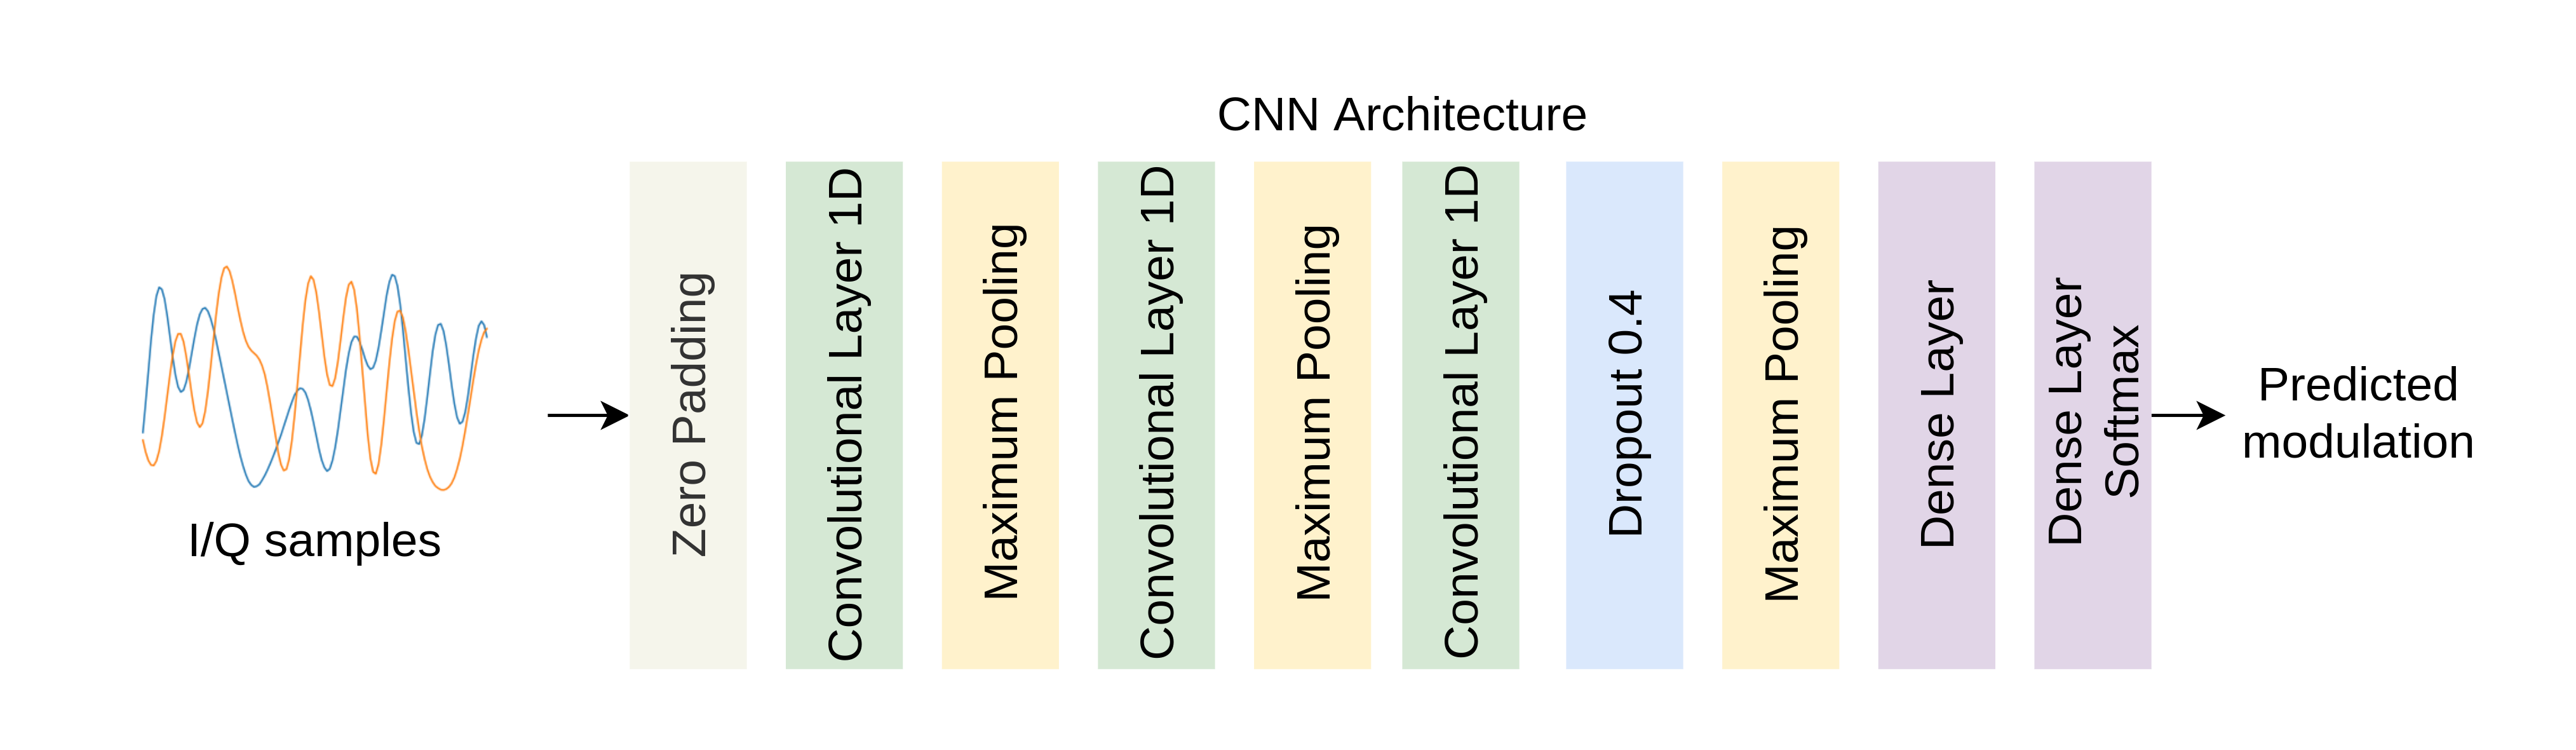

In [ ]:

cnn_in = keras.layers.Input(shape=(128,2))
cnn = keras.layers.ZeroPadding1D(padding=4)(cnn_in)
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu')(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu')(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Conv1D(filters=50, kernel_size=4, activation='relu')(cnn)
cnn = keras.layers.Dropout(rate=0.6)(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Flatten()(cnn)
cnn = keras.layers.Dense(70, activation='selu')(cnn)
cnn_out = keras.layers.Dense(len(mods), activation='softmax')(cnn)

model_cnn = keras.models.Model(cnn_in, cnn_out)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "cnn_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, min_lr=0.00007),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1)]

optimizer = keras.optimizers.Adam(learning_rate=0.0007)

model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# model_cldnn.summary()

In [ ]:
tf.keras.backend.clear_session()
history = model_cnn.fit(X_train, Y_train, batch_size=128, epochs=4, verbose=2, validation_data= (X_valid, Y_valid), callbacks=callbacks)


In [ ]:
model = keras.models.load_model("cnn_model.h5")

test_loss, test_acc = model.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

In [ ]:
SNR_accuracy(SNR, 'CNN')

## CLDNN

In [ ]:
layer_in = keras.layers.Input(shape=(128,2))
layer = keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu')(layer_in)
layer = keras.layers.MaxPool1D(pool_size=2)(layer)
layer = keras.layers.LSTM(64, return_sequences=True,)(layer)
layer = keras.layers.Dropout(0.4)(layer)
layer = keras.layers.LSTM(64, return_sequences=True,)(layer)
layer = keras.layers.Dropout(0.4)(layer)
layer = keras.layers.Flatten()(layer)
layer_out = keras.layers.Dense(len(mods), activation='softmax')(layer)

model_cldnn = keras.models.Model(layer_in, layer_out)

optimizer = keras.optimizers.Adam(learning_rate=0.0007)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "cldnn_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.4, patience=5, min_lr=0.000007),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, verbose=1)]

model_cldnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# model_cldnn.summary()

In [ ]:
tf.keras.backend.clear_session()
history = model_cldnn.fit(X_train, Y_train, batch_size=128, epochs=100, verbose=2, validation_data= (X_valid, Y_valid), callbacks=callbacks)
# history = model_iq.fit(X_train, Y_train, batch_size=128, epochs=100, verbose=2, validation_split=0.15, callbacks=callbacks)


In [ ]:
model = keras.models.load_model("cldnn_model.h5")

test_loss, test_acc = model.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

In [ ]:
SNR_accuracy(SNR, 'CLDNN')

## CGDNN

In [ ]:
layer_in = keras.layers.Input(shape=(128,2)) 
layer = keras.layers.Conv1D(filters=80, kernel_size=(12), activation='relu')(layer_in)
layer = keras.layers.MaxPool1D(pool_size=(2))(layer)
layer = keras.layers.GRU(40, return_sequences=True)(layer)
layer = keras.layers.GaussianDropout(0.4)(layer)
layer = keras.layers.GRU(40, return_sequences=True)(layer)
layer = keras.layers.GaussianDropout(0.4)(layer)
layer = keras.layers.Flatten()(layer)
layer_out = keras.layers.Dense(10, activation='softmax')(layer)

model_CGDNN = keras.models.Model(layer_in, layer_out)

optimizer = keras.optimizers.Adam(learning_rate=0.002)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "cgdnn_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.4, patience=4, min_lr=0.000007),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)]

model_CGDNN.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# model_CGDNN.summary()

In [ ]:
tf.keras.backend.clear_session()
history = model_CGDNN.fit(X_train, Y_train, batch_size=128, epochs=100, verbose=2, validation_data=(X_valid,Y_valid), callbacks=callbacks)

In [ ]:
model = keras.model_CGDNN.load_model("cgdnn_model.h5")

test_loss, test_acc = model.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

SNR_accuracy(SNR, 'CLGDNN')

## Transformer

In [ ]:
embed_dim = 64  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 16  # Hidden layer size in feed forward network inside transformer

inputs = keras.layers.Input(shape=(128,2))
x = keras.layers.Conv1D(filters=embed_dim, kernel_size=8, activation='relu')(inputs)
x = keras.layers.MaxPool1D(pool_size=2)(x)
x = keras.layers.LSTM(embed_dim, return_sequences=True,)(x)
x = keras.layers.Dropout(0.4)(x)

pos_emb = position_encoding_init(60,64)
x_pos = x+pos_emb

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x_pos)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(len(mods), activation="softmax")(x)

model_MCT = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# model_MCT.summary()

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.03)
model_MCT.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model_MCT.fit(X_train, Y_train, batch_size=16, epochs=20, validation_data= (X_valid, Y_valid))

Uncomment and lower the learning rate, if the validation loss doesn't improve.

In [ ]:
# optimizer = keras.optimizers.SGD(learning_rate=0.01)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# history = model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_data= (X_valid, Y_valid))

In [ ]:
# optimizer = keras.optimizers.SGD(learning_rate=0.005)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# history = model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_data= (X_valid, Y_valid))

In [ ]:
# optimizer = keras.optimizers.SGD(learning_rate=0.001)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# history = model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data= (X_valid, Y_valid))

In [ ]:
test_loss, test_acc = model_MCT.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)
SNR_accuracy(SNR, 'MCT')

# Load saved models

In [ ]:
# model = tf.keras.models.load_model(base_dir+"cgd_model_10a.h5") #specify your own location 

# prediction = model.predict([X_test[:,:,:]])

# Y_Pred = []; Y_Test = []; Y_Pred_SNR = []; Y_Test_SNR = []; 
# for i in range(len(prediction[:,0])):
#     Y_Pred.append(np.argmax(prediction[i,:]))
#     Y_Test.append(np.argmax(Y_test[i]))

# Y_Pred[:20], Y_Test[:20]


# Visualize activation and feature map 

In [ ]:
model_visualization(1,9000, mods, model)

# Plot Confusion Matrix

In [ ]:
All_SNR_show_confusion_matrix([X_test], save=False)

In [ ]:
SNR_show_confusion_matrix(mods, lbl_SNR[:], X_test, save=False)